# Import

In [296]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [321]:
credits_df = pd.read_csv('../data/tmdb_5000_credits.csv')
movies_df = pd.read_csv('../data/tmdb_5000_movies.csv')

# EDA and Preprocessing

In [322]:
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [323]:
credits_df.columns = ['id', 'title', 'cast', 'crew']

In [324]:
movies_df.merge(credits_df, on='id')

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,Newlyweds,"[{

In [299]:
raw_mail_data.shape

(5572, 2)

In [300]:
raw_mail_data.isnull().sum()

Category    0
Message     0
dtype: int64

In [301]:
raw_mail_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [302]:
raw_mail_data.loc[raw_mail_data['Category'] == 'spam', 'Category',] = 1
raw_mail_data.loc[raw_mail_data['Category'] == 'ham', 'Category',] = 0

In [303]:
raw_mail_data['Category'] = raw_mail_data['Category'].astype('float')

<Axes: xlabel='Category', ylabel='Count'>

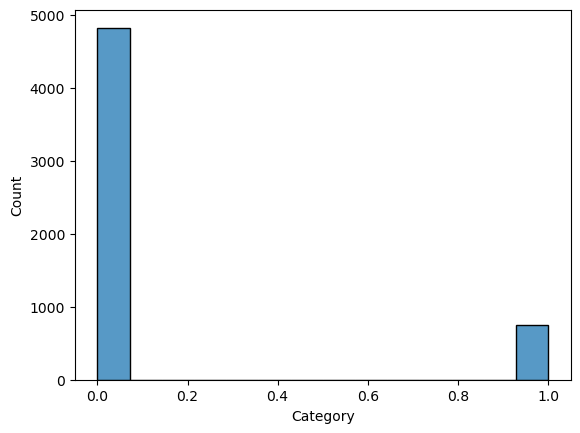

In [304]:
sns.histplot(raw_mail_data['Category'])

In [305]:
raw_mail_data['Category'].count()

5572

# Train and Evaluate model

In [306]:
X = raw_mail_data['Message']
y = raw_mail_data['Category']

In [307]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase=True)

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

y_train = Y_train.astype('int')
y_test = Y_test.astype('int')

In [309]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

In [310]:
model_cv = HalvingGridSearchCV(SVC(probability=True), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [311]:
model_cv.fit(X_train_features, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 165
max_resources_: 4457
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 165
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n_resources: 495
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 2
n_candidates: 4
n_resources: 1485
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 4455
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
                    param_grid={'C': [0.1, 1, 10, 100],
                                'gamma': [0.0001, 0.001, 0.01, 0.1],
                                'kernel': ['linear', 'rbf']},
                    scoring='accuracy', verbose=1)

In [312]:
best_model = model_cv.best_estimator_
predictions = best_model.predict(X_test_features)

In [313]:
print(best_model)

SVC(C=100, gamma=0.01, probability=True)


In [314]:
prediction_on_training_data = best_model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)

In [315]:
print('Accuracy on training data : ', accuracy_on_training_data)

Accuracy on training data :  0.9997756338344178


In [316]:
prediction_on_test_data = best_model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)

In [317]:
print('Accuracy on test data : ', accuracy_on_test_data)

Accuracy on test data :  0.9919282511210762


In [318]:
input_mail = '''I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times'''

# convert text to feature vectors
input_data_features = feature_extraction.transform([input_mail])

# making prediction

prediction = best_model.predict(input_data_features)
print(prediction)


if (prediction[0]==1):
    print('Spam mail')
else:
    print('Ham mail')

[0]
Ham mail


# Saving Model

In [319]:
import joblib

In [320]:
joblib.dump(best_model, 'spam_detection_model.pkl')
joblib.dump(feature_extraction, 'feature_extraction.pkl')

['feature_extraction.pkl']